## Q1.Graph

**American College football:** network of American football games between Division IA colleges during regular season Fall 2000, an Undirected and Unweighted Graph. The nodes have values that indicate to which conferences they belong.  The values are as follows:
```raw
  0 = Atlantic Coast
  1 = Big East
  2 = Big Ten
  3 = Big Twelve
  4 = Conference USA
  5 = Independents
  6 = Mid-American
  7 = Mountain West
  8 = Pacific Ten
  9 = Southeastern
 10 = Sun Belt
 11 = Western Athletic
 ```

In [1]:
import networkx as nx
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import copy

print(nx.__version__)

3.4.1


In [2]:
competition_net = nx.read_gml("football/football.gml")
competition_net = nx.Graph(competition_net)

print(type(competition_net).__name__)

Graph


## Q2.Hypotheses

- **Hypothesis 1**

    在这个网络中，度数越大的节点说明有更多的大学愿意与它一起比赛，这可能是因为这个学校橄榄球队的实力强劲，受欢迎程度高，多数学校希望挑战它。因此，我们提出假设：那些实力强劲的学校之间更愿意两两相互比赛，从而提高实力，而实力较弱的学校也倾向于与和自己水平相近的学校比赛，以避免被碾压。

- **Hypothesis 2**

    我的第二个假设是那些实力强或是受欢迎程度高的学校之间存在着一个联盟，他们彼此之间联系紧密，相互聚集在一起，并且与低水平、低人气球队之间来往频率低。

- **Hypothesis 1 Addition**

    对假设1进行补充，两个球队之间是否进行比赛，还有可能的是学校本身的一些属性，即在相同协会之间的学校之间由于形成了协会这一较为紧密的群体，相比于实力水平是否接近，同一协会之间的学校更有可能相互交流学习，进行比赛。所以，提出假设：同一协会的学校之间更倾向于相互比赛，而排斥与不同协会的学校进行比赛。


## Q3.Measures

- **Hypothesis 1**

    使用同配性对假设进行检验，同配性用作考察度值相近的顶点是否倾向于互相连接。如果总体上度大的顶点倾向于连接度大的顶点，那么就称网络的度正相关的，或者称网络是同配的；如果总体上度大的顶点倾向于连接度小的顶点，那么就称网络的度负相关的，或者成称络是异配的。使用Networkx的degree_assortativity_coefficient方法可以计算度同配性系数。
    r>0表示整个网络呈同配性结构，度大的节点倾向于和毒打的节点相连；r<0表示整个网络呈现易配性；r=0表示网络结构不存在相关性。

- **Hypothesis 2**

    使用富人俱乐部系数对假设进行检验，富人俱乐部指的是网络中度值高的节点之间的连接，往往表示出比度值低的节点之间的连接更加紧密的趋势，这些高度值的节点在全局交流中具有重要的作用。

- **Hypothesis 1 Addition**

    同配概念的一般化，同配就是指属性相近的节点倾向于互相连接，这里的属性可以是度也可以是其他特性。这里我使用节点的value属性，即每所大学所属的协会，同样使用同配性对假设进行检验，通过Networkx的attribute_assortativity_coefficient方法计算属性同配系数。


## Q4.Result and Analysis

In [3]:
real_assortativity = nx.degree_assortativity_coefficient(competition_net)
print(f"Real Assortativity Coefficient is {real_assortativity}")

real_rich_club = nx.rich_club_coefficient(competition_net,normalized=False, seed=2024)[10]
print(f"Real Rich Club Coefficient is {real_rich_club}")

Real Assortativity Coefficient is 0.16244224957444287
Real Rich Club Coefficient is 0.10656010656010656


Networkx的Assortativity Coefficient在-1~1，值大于0表示有同配性，小于0表示有异配性，等于0表示均等连接，绝对值数值越大，说明其倾向性越高。Rich Club Coefficient该指标是通过将网络分割成等度的节点，然后使用k度节点之间的连接数除以k度节点之间所有可能的连接数，将这个比值作为富人俱乐部系数，范围是0~1，该系数越大表明rich-club节点之间的连接更加紧密。


上面的数据显示大学之间的橄榄球比赛呈现出一定的度同配性，但同配系数较低，表面上看，的确有比赛数量接近的学校之间更可能相互连接（即进行比赛）的倾向，而比赛数量还可能隐含着一些的潜在特征，例如球队的实力、学校的交流、资金的支持等不在网络数据中的特征，正是这些更深层次的特征导致了这种连接倾向。该网络节点的度数范围是0-11，将度数大于或等于10度的节点定义为“富人”节点。令人惊讶的是，发现在橄榄球比赛中富人俱乐部系数仅为0.1，说明在橄榄球队之间并没有隐世不出的“高雅”的内部圈层，球队之间的比赛较为对外开放，愿意去交流学习，相互竞争，共同进步。

In [4]:
competition_degree_sequence = list(dict(nx.degree(competition_net)).values())

# We need to generate enough null graphs to make a reasonable assessment of the null distribution
model_assortativity = []
model_rich_club = []
for i in range(1000):
    # Use the configuration model to create a null graph
    null_graph = nx.configuration_model(competition_degree_sequence)
    null_graph = nx.Graph(null_graph) # removes parallel edges
    null_graph.remove_edges_from(nx.selfloop_edges(null_graph)) # removes self-loops
    model_assortativity.append(nx.degree_assortativity_coefficient(null_graph))
    try:
        model_rich_club.append(nx.rich_club_coefficient(null_graph, normalized=False, seed=2024)[11])
    except KeyError as e:
        model_rich_club.append(0)

In [5]:
zscores_1 = stats.zscore([real_assortativity] + model_assortativity)
zscores_2 = stats.zscore([real_rich_club] + model_rich_club)

print(f"zscores of assortativity is {zscores_1[0]}\nzscores of rich_club is {zscores_2[0]}")

zscores of assortativity is 3.638992991318851
zscores of rich_club is -0.24779094881179975


z分数（Z-Score），也叫标准分数（standard score）是一个数与平均数的差再除以标准差的过程，Z-Score能够真实的反映一个分数距离平均数的相对标准距离。Z-Score能够应用于数值型的数据，并且不受数据量级的影响，正态分布是最有利于Z-Score计算，从Chart 1中可以看出数据大体上呈正太分布，因此可以有效合理地使用Z-Score。

计算度同配性的零模型与真实网络的Z-Score较大，说明真实的球队比赛网络之间的同配性质，与度序列无关，并不是随机造成的，因此可以认为球队比赛网络本身的结构性质决定了他的同配性。计算富人俱乐部系数的零模型与真实网络之间的Z-Score较低，说明球队之间不存在富人俱乐部现象不是有网络结构或其他属性造成的，从大量随机零模型来看，我们有理由认为这是由网络的度序列决定的。

最后，对于假设一，测试接受了原假设，比赛次数多的学校之间更倾向于和其他受欢迎的、比赛次数多的学校比赛，比赛次数少的学校之间倾向于报团取暖、相互比赛，这与网络自身结构性质有关，与度序列无关。
对于假设二，测试拒绝了原假设，球队比赛之间不存在一个“贵族”联盟，比赛多的学校之间没有形成一个紧密排外的集团，并且有理由认为这与网络的度序列有关。

**Addition**

In [6]:
real_attr_assortativity = nx.attribute_assortativity_coefficient(competition_net, "value")

print(real_attr_assortativity)

0.6079383668260255


对假设一进行补充，对同配概念进行一般化。网络节点属性同配系数很高，约为0.6，是度同配系数的3-4倍。说明节点之间在同一属性下连接的可能性很高，即学校球队多数情况下只与同一个协会之间的学校球队进行比赛，并且从系数数值上看，节点的value属性（所属协会）似乎比节点的度更能解释网络的同配性质，但还需与零模型比较，测试其是普遍存在或是有其独特性。

analysis

In [7]:
def my_null_model(graph:nx.Graph):
    # 基于断边重连的1阶度分布零模型
    random_graph = copy.deepcopy(graph) # 防止修改原网络
    for _ in range(graph.number_of_edges()*2): # 设置交换次数
        nx.double_edge_swap(random_graph) # 随机交换两条边的连接，并且不改变节点的度数
    return random_graph

In [8]:
model_attr_assortativity = []
for j in range(1000):
    null_graph = my_null_model(competition_net)
    model_attr_assortativity.append(nx.attribute_assortativity_coefficient(null_graph, "value"))
    # print(f"\r {j+1} / 1000", end='\r')

In [9]:
zscores_3 = stats.zscore([real_attr_assortativity] + model_attr_assortativity)

print(zscores_3[0])

26.442709384264244


对于假设一的补充，Z-Score非常大，说明这个属性同配性并不是普遍存在于随机生成的零模型中，与假设一相同，有理由认为这是由与网络自身结构性质造成，与度序列无关。因此，我们有理由接受对假设一的补充假设，同一协会的学校之间更倾向于相互比赛，排斥与不同协会的学校进行比赛。

### Illustration

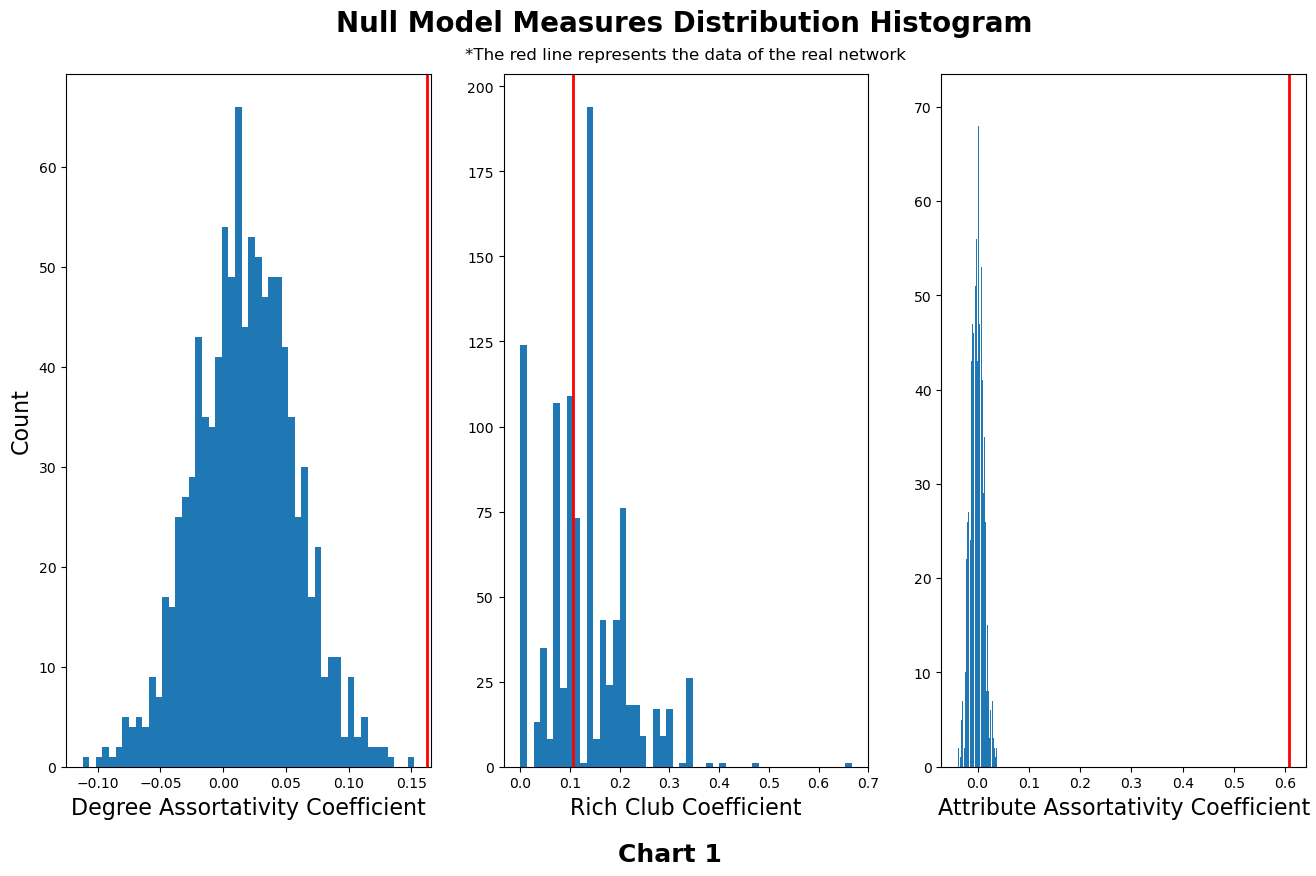

In [10]:
plt.figure(figsize=(16, 9))
# chart1.1
plt.subplot(131)
plt.hist(model_assortativity, bins=50)
plt.axvline(real_assortativity, lw=2, color="red")
plt.xlabel("Degree Assortativity Coefficient", fontsize=16)
plt.ylabel("Count", fontsize=16)
# chart1.2
plt.subplot(132)
plt.hist(model_rich_club, bins=50)
plt.axvline(real_rich_club, lw=2, color="red")
plt.xlabel("Rich Club Coefficient", fontsize=16)
# chart1.3
plt.subplot(133)
plt.hist(model_attr_assortativity, bins=50)
plt.axvline(real_attr_assortativity, lw=2, color="red")
plt.xlabel("Attribute Assortativity Coefficient", fontsize=16)
# label
plt.text(-1.25, 78, "Null Model Measures Distribution Histogram", fontsize=20, fontweight="bold")
plt.text(-1.0, 75, "*The red line represents the data of the real network", fontsize=12)
plt.text(-0.7, -10, "Chart 1", fontsize=18, fontweight="bold")
plt.show()

Chart 1显示了零模型在不同的度量标准上的分布情况，从图形上看，三幅图都大体符合正态分布。真实网络的度同配系数几乎超出了零模型分布的置信区间，而属性同配系数则是远远超过，有理由认为它们表现的性质与度序列无关；真实网络的富人俱乐部系数处在零模型分布区间内部，有理由认为这无法摆脱度序列的影响，其低富人俱乐部系数可能由度序列造成。

## Q5.Realization

通过这个测验，我发现在美国大学橄榄球队的比赛网络中，这个网络是同配的，并且很大程度上是因为节点所属协会这个属性，是的协会相同的节点更倾向与相互连接，并且该网络中并不存在度值高的节点之间更强更紧密的连接，即高度节点之间的连接没有比低度节点更紧密。